In [75]:
from sys import path as syspath
from os import path as ospath
import pickle

syspath.append(ospath.join(ospath.expanduser("~"), 'CBSA'))

from cbsa import ReactionSystem

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def switch_time_gaps(data):
    tf_str = "".join([str(int(data[i,1])) for i in range(data.shape[0])])
    tf_steps = [step.split("10") for step in tf_str.split("01")]
    tf_steps  = [len(item)+2 for sublist in tf_steps  for item in sublist]
    tf_steps[0] -= 1
    tf_steps[-1] -= 1
    cumsum = [0]+list(np.cumsum(tf_steps))
    time_steps = np.diff(data[:,0])
    tf_times = {0:[],1:[]}
    value = 0
    for i in range(1,len(cumsum)):
        time = np.sum(time_steps[cumsum[i-1]:cumsum[i]])
        tf_times[value].append(time)
        if value:
            value = 0
        else:
            value = 1
    return tf_times

def mean_value(data,index):
    time_steps = np.append(np.array([0.]),np.diff(data[:,0]))
    sum_ts = np.sum(time_steps)
    if not sum_ts: return 0.
    return np.sum(time_steps*data[:,index])/np.sum(time_steps)

In [3]:
S = [[-1,1,0,0],
     [1,-1,0,0],
     [0,0,1,-1]]

R = [[0,0,1,0],
     [0,0,0,0],
     [0,0,0,0]]

x = [0,1,0]
k = [0.05,0.05,200,0.5]

max_dt = 0.1
total_sim_time = 20000
alpha=0.5

cbsa = ReactionSystem(S,R)
cbsa.setup()
cbsa.set_x(x)
cbsa.set_k(k)

In [4]:
cbsa.setup_simulation(use_opencl=False,alpha=alpha,max_dt=max_dt)
cbsa.compute_simulation(total_sim_time,batch_steps=1)
cbsa_data = np.array(cbsa.simulation_data)

with open("cbsa_burst_0.5_0.5_200_0.5.pdata","wb") as f:
    pickle.dump(cbsa_data,f)

In [ ]:
cbsa_data = pickle.load( open( "cbsa_burst_0.5_0.5_200_0.5.pdata", "rb" ) )
switch_times = switch_time_gaps(cbsa_data)
mean_values_Eact = [mean_value(cbsa_data[0:i],1) for i in range(1,len(cbsa_data))]
mean_values_Mol = [mean_value(cbsa_data[0:i],3) for i in range(1,len(cbsa_data))]

In [5]:
from matplotlib import rc
rc('text', usetex=True)
plt.style.use("bmh")
plt.rcParams["font.family"] = "serif"
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

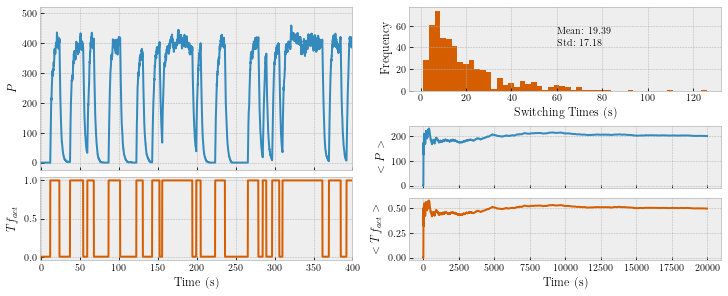

In [82]:


fig = plt.figure(figsize=(10, 4),constrained_layout=True)

gs = fig.add_gridspec(nrows=10, ncols=2)


ax0 = fig.add_subplot(gs[0:6,0:1])
ax1 = fig.add_subplot(gs[6:10,0:1])
ax2 = fig.add_subplot(gs[0:4,1:2])
ax3 = fig.add_subplot(gs[4:7,1:2])
ax4 = fig.add_subplot(gs[7:10,1:2])

#plt.xlim(-1,400)
#plt.xlabel("Time",fontsize=14)
#plt.tick_params(labelsize=12)

#lbl1 = fig.text(0.06, 0.70, '$P$', ha='center', va='center', rotation='vertical',fontsize = 14)
#lbl2 = fig.text(0.06, 0.40, '$Tf_{act}$', ha='center', va='center', rotation='vertical',fontsize = 14)
#lbl3 = fig.text(0.06, 0.175, '$ < Tf_{act} > $', ha='center', va='center', rotation='vertical',fontsize = 14)



ax0.plot(cbsa_data[:,0],cbsa_data[:,3],color=colors[0])
ax0.set_xlim(-1,400)
ax0.set_xticklabels([])
ax0.set_ylabel("$P$")

ax1.plot(cbsa_data[:,0],cbsa_data[:,1],color=colors[4])
ax1.set_xlim(-1,400)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("$Tf_{act}$")

ax2.hist(switch_times[0],bins=50,color=colors[4])
ax2.set_xlabel("Switching Times (s)")
ax2.set_ylabel("Frequency")
ax2.text(60,42,"Mean: "+str(np.round(np.mean(switch_times[0]),2))+"\nStd: "+str(np.round(np.std(switch_times[0]),2)))

ax3.plot(cbsa_data[:,0],[0]+mean_values_Mol,color=colors[0])
ax3.set_xticklabels([])
ax3.set_ylabel("$<P>$")


ax4.plot(cbsa_data[:,0],[0]+mean_values_Eact,color=colors[4])
ax4.set_xlabel("Time (s)")
ax4.set_ylabel("$<Tf_{act}>$")

#lgd = plt.legend(bbox_to_anchor=(0., -1.6, 1., .102), loc=3,
#       ncol=2, mode="expand", borderaxespad=0.,fontsize=10)

plt.savefig("burst.png",dpi=300, bbox_inches='tight')
plt.show()